### Resume and Job Matching

### The code below receives a resume as an input in the format of pdf.
### The code putput is the top matching jobs from the dataset with that resume.

#### Step 1 - Import packages

In [1]:
from __future__ import unicode_literals
from gensim.summarization import keywords
import pandas as pd

import nltk
import string
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import unicodedata
import math
import bytes
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import seaborn as sns
from collections import Counter

import gensim
from gensim.models import Word2Vec
import logging


from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import sys
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams

from io import StringIO

#### Step 2 - Set up the directory

In [2]:
os.chdir(r"C:\Users\khans\Insight\My code")

#### Step 3 - Read the input resume in pdf format and save it as text file in the same directory

In [3]:

def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    # removed from the line above: , codec=codec
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

    return data
    
with open('resumeconverted.txt','w') as f:
    f.write(pdfparser(str(input("Enter resume name: ")+".pdf")))

Enter resume name: Sherry Khansari


#### Step 4 - Import input job dataset csv file 

In [40]:
#df = pd.read_csv(str(input("Enter dataset name: "))+".csv")
df = pd.read_csv("indeed_job_dataset.csv")
df.rename(columns = {'Unnamed: 0':'Job No.'}, inplace = True) 
df.head()

,Job No.,position,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
0,0,Data Scientist,https://www.indeed.com/rc/clk?jk=6a105f495c36a...,<80000,data_scientist,"['SAP', 'SQL']",2,Express Scripts,3301.0,3.3,...,0,0,0,1,0,0,0,1,0,0
1,1,Data Scientist,https://www.indeed.com/rc/clk?jk=86afd561ea8c6...,<80000,data_scientist,"['Machine Learning', 'R', 'SAS', 'SQL', 'Python']",5,Money Mart Financial Services,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,Data Scientist,https://www.indeed.com/rc/clk?jk=e0aad317e6d45...,<80000,data_scientist,"['Data Mining', 'Data Management', 'R', 'SAS',...",9,comScore,62.0,3.5,...,0,0,0,1,0,0,0,0,0,0
3,3,Graduate Studies Program - Data Scientist,https://www.indeed.com/rc/clk?jk=1cfdd9e391a63...,<80000,data_scientist,['Certified Internal Auditor'],1,Central Intelligence Agency,158.0,4.3,...,0,1,0,0,0,0,0,0,0,1
4,4,Data Scientist I,https://www.indeed.com/rc/clk?jk=fec647775a21e...,<80000,data_scientist,"['Statistical Software', 'Time Management', 'R...",7,Federal Reserve Bank of Dallas,495.0,4.1,...,0,0,0,0,0,0,1,0,0,0


#### Step 5 - Let's look at the data a little closer (exploration)

In [5]:
df.shape

(5715, 43)

In [6]:
df["Job Description"].nunique()

4802

In [7]:
df.nunique()

Job No.                             5715
position                            2314
Link                                5715
Queried_Salary                         6
Job_Type                               3
Skill                               4024
No_of_Skills                          21
company                             2231
No_of_Reviews                        754
No_of_Stars                           34
Date_Since_Posted                     30
Job Description                     4802
Location                              51
Company_Revenue                        4
Company_Employees                      2
Company_Industry                      33
python                                 2
sql                                    2
machine learning                       2
r                                      2
hadoop                                 2
tableau                                2
sas                                    2
spark                                  2
java            

#### Step 6 - Converting job title, description, and company name to list


#### Step 7 -  Building the models (modified from version 2)

##### 7A - Preprocess text lists

In [41]:
def preprocess(text):
    """ preprocess text: remove special characters, remove digits, tokenize,
    lowercase, remove stopwords, lemmatize
    """
    # preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
    tokenizer = RegexpTokenizer(r'\w+')
    #stopwords_en = set(stopwords.words('english'))
    stopwords_en = nltk.corpus.stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub('[^a-zA-Z]', ' ', text )
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens if len(token)>2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]
    return ' '.join(tokens)

In [42]:
# preprocess job title and description
for col in ['position', 'Job Description']:
    df[col] = df[col].astype(str)
    df[col+'_processed'] = df[col].apply(preprocess)

df.head()

# have a column for both title and descritpion
cols = ['position_processed', 'Job Description_processed']
df['title_and_desc'] = df[cols].apply(lambda x: ' '.join(x), axis=1)

In [43]:
#jd = df['Job Description_processed'].tolist()
#companies = df['company'].tolist()
#positions = df['position_processed'].tolist()

jd = df['Job Description'].tolist()
companies = df['company'].tolist()
positions = df['position'].tolist()

In [45]:
# Choose final columns needed for analysis and save the scv file
df = df[['position_processed', 'Job Description_processed','Job Description','company']]

df.to_csv("clean_data.csv")
#df.head()

In [46]:
len(jd)

5715

In [47]:
df.shape

(5715, 4)

##### Open the resume and add it to the cleaned dataset

In [48]:
with open('resumeconverted.txt','r') as f:
    resume = f.read()
    
    
resume = preprocess(resume)
jd.append(resume)

In [49]:
len(jd)

5716

In [50]:
jd[-1]

'sherry khansari phd khansari shahrzad gmail com led multiple team engineer pm delivering high visibility program pepsico held several training business function new technology including python uipath familiar azure cognitive service experience algorithm data structure background machine learning model end end deployment product experience product manager automation pepsico seattle nov present product delivery delivered product across several technology including robotic process automation machine learning north america latin america europe middle east singapore australia managed operation product life cycle requirement gathering design development testing deployment cloud platform worked engineering data science security control team build test ship product supported conversational product machine learning use case including forecasting led launch robotic process automation use case annual productivity hour recommendation roadmap strategy defined analyzed metric product prioritization

#### Have a look at most frequent words in columns

In [19]:
def plot_common_words(df, column, n):
    """plot n most common words in a column of a df"""
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of n most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

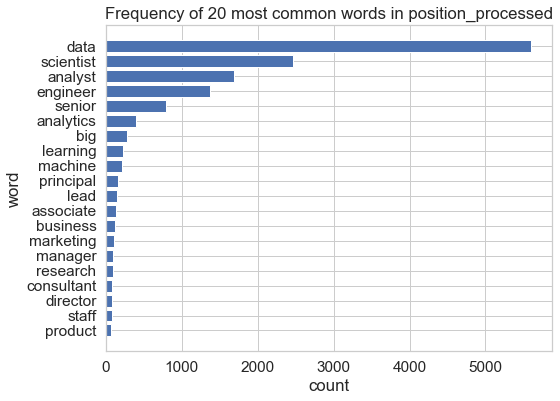

In [20]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(df, 'position_processed', 20) 

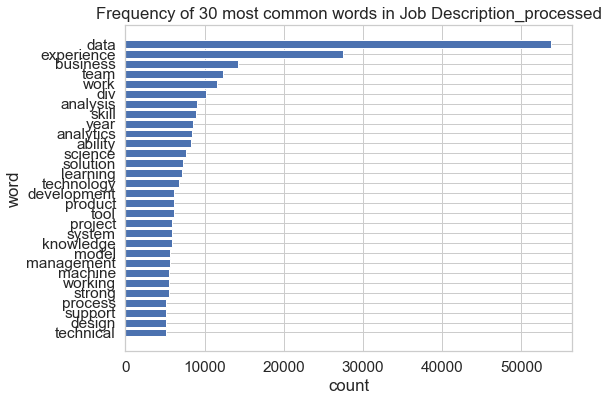

In [21]:
plot_common_words(df, 'Job Description_processed', 30)

##### CountVectorizer Class

In [22]:
class MyCountVectorizer:
    def __init__(self, docs):
        self.corpus = self.normalize_corpus(docs)
        self.make_features()
        self.make_matrix()
        
    def normalize_corpus(self, docs):    
        #table = string.maketrans(string.punctuation, 
         #                        len(string.punctuation) * ' ')
        
        #table = str.rstrip(string.punctuation, 
        #                         len(string.punctuation) * ' ')
        
        table = str.maketrans('', '', string.punctuation)
        
        
        
        norm_docs = []
        for doc_raw in docs:
            doc = filter(lambda x: x in string.printable, doc_raw)
            '''
            doc = ''
            for x in doc_raw:
                if x in string.printable:
                    doc += x
            '''
            doc = str(doc).translate(table).lower()
            norm_docs.append(doc)
        #self.corpus = norm_docs
        return norm_docs
        
    def make_features(self):
        ''' create vocabulary set from the corpus '''
        stopwords = nltk.corpus.stopwords.words('english')
        self.features = set()
        for doc in self.corpus:
            for word in doc.split():
                if word not in stopwords:
                    self.features.add(word)
        #self.features = set([word for doc in self.corpus for word in doc.split() if word not in stopwords])
        self.features = sorted(list(self.features))

    def make_matrix(self):
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                doc_vec.append(tf)
            self.matrix.append(doc_vec)

    def term_freq(self, term, document):
        words = document.split()
        count = 0
        for word in words:
            if word == term:
                count += 1
        return count
    
    def print_matrix(self):
        for vec in self.matrix:
            print(vec)

    def get_matrix(self):
        return self.matrix
    
    def get_features(self):
        return self.features
    
    def get_density(self):
        ''' get the density (# of non-zero elements / # all elements )'''
        counter = 0
        total = 0
        for row in self.matrix:
            for item in row:
                if item != 0:
                    counter += 1
                total += 1
        return 1.0 * counter / total

##### TFIDF Vectorizer

In [23]:
class MyTfIdfVectorizer(MyCountVectorizer):
    ''' inherits from MyCountVectorizer'''

    def make_matrix(self):
        'overriding method'
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                idf = self.inverse_document_freq(word)
                doc_vec.append(tf * idf)
            #self.matrix.append(doc_vec)
            total = sum(doc_vec)
            doc_vec_norm = [i/total for i in doc_vec]
            self.matrix.append(doc_vec_norm)

    def inverse_document_freq(self, term):
        doc_count = 0
        for document in self.corpus:
            term_count = self.term_freq(term, document)
            if term_count > 0:
                doc_count += 1
        return math.log( 1.0 * len(self.corpus) / doc_count)

##### Plotting

In [24]:
def plot_mds(mean_vec):   
    from sklearn.manifold import MDS
    data = mean_vec
    mds = MDS(n_components=2, random_state=1)
    pos = mds.fit_transform(data)
    xs,ys = pos[:,0], pos[:,1]
    for x, y in zip(xs, ys):
        plt.scatter(x, y)
    #    plt.text(x, y, name)
    #pos2 = mds.fit_transform(model.infer_vector(resume))
    #xs2,ys2 = pos2[:,0], pos2[:,1]
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.suptitle('MDS')
    plt.grid()
    plt.savefig('distance_MDS_improved.png')
    plt.show()

def plot_pca(meav_vec):
    from sklearn.decomposition import PCA
    data = mean_vec
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    plt.savefig('distance_PCA_improved.png')
    plt.show()

##### Vectorize the jd list

In [25]:

myvec = MyTfIdfVectorizer(jd)

In [71]:
myvec

In [73]:


# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

#### Build the model (word2vec)

In [28]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [227]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

In [26]:
model = wv

NameError: name 'wv' is not defined

In [29]:
model

In [222]:
word_vectors = model.wv

C:\Users\khans\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [223]:
word_vectors

In [ ]:
#import gensim.downloader as api

#model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
#word_vectors = model.wv #load the vectors from the model

In [ ]:
#from gensim.models.word2vec import Word2Vec
#model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#model.save_word2vec_format('googlenews2.txt')

In [30]:
len(jd)

5716

In [51]:
stopwords = nltk.corpus.stopwords.words('english')

imp = ['java']
vec = []

for j in jd:
    x = j.translate(str.maketrans('', '', string.punctuation))
    y = x.translate(str.maketrans('', '', string.digits))
    jd_vector = []
    i = 0
    
    for word in y.split():
        if word.lower() not in stopwords and len(word)>2 and word not in imp:
            try:
                x = model[word]
                idx = myvec.get_features().index(word)
                z = myvec.get_matrix()[i][idx]
                lst = [a * z for a in x]
                jd_vector.append(lst)
            except:
                continue
    
        else:
            try:
                x = model[word]
                lst = [a * 2 for a in x]
                jd_vector.append(lst)
            except:
                continue
    i+=1
    vec.append(jd_vector)

In [52]:
len(vec)

5716

In [53]:
vec[5]

[[0.1162109375,
  -0.0003490447998046875,
  0.15234375,
  0.1064453125,
  0.05029296875,
  0.041748046875,
  -0.138671875,
  -0.265625,
  -0.138671875,
  0.328125,
  -0.2099609375,
  -0.16015625,
  -0.1083984375,
  0.058837890625,
  -0.2041015625,
  -0.051025390625,
  0.28515625,
  0.302734375,
  -0.038330078125,
  0.0279541015625,
  -0.1513671875,
  0.189453125,
  -0.2578125,
  -0.1513671875,
  -0.01556396484375,
  -0.26953125,
  0.09814453125,
  0.32421875,
  0.236328125,
  -0.0634765625,
  0.146484375,
  -0.34765625,
  -0.1572265625,
  0.00194549560546875,
  -0.33203125,
  0.2255859375,
  -0.236328125,
  -0.2177734375,
  -0.306640625,
  0.30859375,
  -0.07568359375,
  -0.162109375,
  0.05322265625,
  -0.0595703125,
  -0.1533203125,
  -0.01422119140625,
  -0.26953125,
  -0.2275390625,
  -0.08154296875,
  0.0947265625,
  -0.08740234375,
  0.0201416015625,
  0.0286865234375,
  -0.1259765625,
  -0.12890625,
  0.369140625,
  -0.27734375,
  0.248046875,
  0.1669921875,
  -0.232421875,
  -

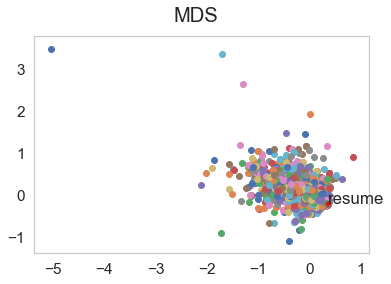

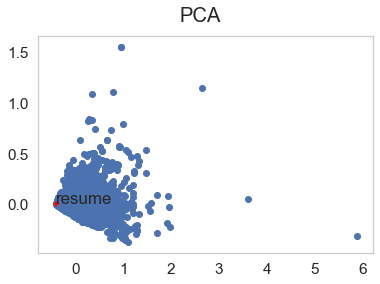

In [56]:
mean_vec = []
for j in vec:
    mean = []
    for i in range(300):
        accum =0
        for word in j:
            accum += word[i]
        mean.append(1.0*accum/len(word))
    mean_vec.append(mean)
data = mean_vec

plot_mds(mean_vec)
plot_pca(mean_vec)
        

In [151]:
import numpy as np
v1,v2 = [3, 45, 7, 2], [2, 54, 13, 15]
v1 = np.array(v1)
v2 = np.array(v2)
v1 = v1.reshape(1,-1)
v2 = v2.reshape(1,-1)
print(cosine_similarity(v1,v2))

[[0.97228425]]


In [255]:
v1 = np.array(vec[0])
v2 = np.array(vec[-1])
v1 = v1.reshape(1,-1)
v2 = v2.reshape(1,-1)
cosine_similarity(v1, v2)

array([[1.]])

In [54]:
vec[0]

[[-0.1142578125,
  0.25,
  -0.203125,
  0.76171875,
  -0.423828125,
  -0.314453125,
  -0.1826171875,
  0.310546875,
  -0.1533203125,
  -0.14453125,
  -0.22265625,
  -0.6171875,
  -0.181640625,
  0.298828125,
  -0.412109375,
  0.18359375,
  0.02978515625,
  0.9921875,
  -0.10302734375,
  -0.333984375,
  -0.73046875,
  -0.412109375,
  0.21484375,
  -0.10693359375,
  -0.30859375,
  -0.255859375,
  -0.8828125,
  0.7578125,
  -0.3828125,
  -0.01458740234375,
  0.2294921875,
  -0.36328125,
  -0.8203125,
  -0.609375,
  -0.8828125,
  0.0181884765625,
  -0.34765625,
  0.640625,
  -0.369140625,
  0.302734375,
  0.330078125,
  -0.49609375,
  -0.62890625,
  0.2216796875,
  0.2890625,
  0.134765625,
  -0.3046875,
  -0.365234375,
  -0.06787109375,
  0.059814453125,
  -0.55078125,
  0.60546875,
  -0.5234375,
  0.2578125,
  0.326171875,
  0.4296875,
  -0.208984375,
  -0.1943359375,
  0.07421875,
  -0.70703125,
  -0.46484375,
  -0.1455078125,
  -0.39453125,
  -0.002655029296875,
  -0.208984375,
  -1.21

In [260]:
vec[2]

IndexError: index 2 is out of bounds for axis 0 with size 1

In [57]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
cos_dist =[]

data[-1] = np.array(data[-1])
data[-1] = data[-1].reshape(1,-1)

for vec in data[:-1]:
    vec = np.array(vec)
    vec = vec.reshape(1,-1)
    cos_dist.append(float(cosine_distances(vec,data[-1])))
    

ps = PorterStemmer()
key_list =[]

for j in jd[:-1]:
    key = ''
    w = set()
    for word in keywords(j).split('\n'):
        w.add(ps.stem(word))
    for x in w:
        key += '{} '.format(x)
    key_list.append(key)


In [58]:
summary = pd.DataFrame({
        'Company': companies,
        'Postition': positions,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
    'Job Description': jd[:-1]
    })


In [59]:
summary.head()

,Company,Postition,Cosine Distances,Keywords,Job Description
0,Express Scripts,Data Scientist,0.871277,client compani opportun employ univers report ...,"[<p><b>POSITION SUMMARY</b></p>, <p>\r\r\nThe ..."
1,Money Mart Financial Services,Data Scientist,0.898173,commun analyt document develop paid learn leve...,"[<p><b>What do we need?</b></p>, <ul><li>\r\r\..."
2,comScore,Data Scientist,0.907781,client tabl report effici larg sa skill find t...,"[<ul><li>Validate, analyze, and conduct statis..."
3,Central Intelligence Agency,Graduate Studies Program - Data Scientist,0.849277,digit success employ scientist innov global be...,"[<p>Full time</p>, <p>Washington, DC metro are..."
4,Federal Reserve Bank of Dallas,Data Scientist I,0.895019,tool excel report organiz high skill strong cu...,[<ul><li>Assist in consultations with business...


In [60]:
z =summary.sort_values('Cosine Distances', ascending=False)
z.to_csv('Summaryimproved.csv',encoding="utf-8")